<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agentchat_groupchat_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Group Chat with Coder and Visualization Critic

`flaml.autogen` offers conversable agents powered by LLM, tool or human, which can be used to perform tasks collectively via automated chat. This framwork allows tool use and human participance through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

## Requirements

FLAML requires `Python>=3.8`. To run this notebook example, please install flaml with the [autogen] option:
```bash
pip install flaml[autogen]
```

In [1]:
%%capture --no-stderr
# %pip install flaml[autogen]~=2.0.3

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [2]:
from flaml import autogen

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)
# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": {
#             "gpt-3.5-turbo",
#             "gpt-3.5-turbo-16k",
#             "gpt-3.5-turbo-0301",
#             "chatgpt-35-turbo-0301",
#             "gpt-35-turbo-v0301",
#         },
#     },
# )

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Construct Agents

In [3]:
llm_config = {"config_list": config_list_gpt4, "seed": 42}
user_proxy = autogen.UserProxyAgent(
   name="User_proxy",
   system_message="A human admin.",
   code_execution_config={"last_n_messages": 3, "work_dir": "groupchat"},
   human_input_mode="NEVER",
)
coder = autogen.AssistantAgent(
    name="Coder",  # the default assistant agent is capable of solving problems with code
    llm_config=llm_config,
)
critic = autogen.AssistantAgent(
    name="Critic",
    system_message="""Critic. You are a helpful assistant highly skilled in evaluating the quality of a given visualization code by providing a score from 1 (bad) - 10 (good) while providing clear rationale. YOU MUST CONSIDER VISUALIZATION BEST PRACTICES for each evaluation. Specifically, you can carefully evaluate the code across the following dimensions
- bugs (bugs):  are there bugs, logic errors, syntax error or typos? Are there any reasons why the code may fail to compile? How should it be fixed? If ANY bug exists, the bug score MUST be less than 5.
- Data transformation (transformation): Is the data transformed appropriately for the visualization type? E.g., is the dataset appropriated filtered, aggregated, or grouped  if needed? If a date field is used, is the date field first converted to a date object etc?
- Goal compliance (compliance): how well the code meets the specified visualization goals?
- Visualization type (type): CONSIDERING BEST PRACTICES, is the visualization type appropriate for the data and intent? Is there a visualization type that would be more effective in conveying insights? If a different visualization type is more appropriate, the score MUST BE LESS THAN 5.
- Data encoding (encoding): Is the data encoded appropriately for the visualization type?
- aesthetics (aesthetics): Are the aesthetics of the visualization appropriate for the visualization type and the data?

YOU MUST PROVIDE A SCORE for each of the above dimensions.
{bugs: 0, transformation: 0, compliance: 0, type: 0, encoding: 0, aesthetics: 0}
Do not suggest code. 
Finally, based on the critique above, suggest a concrete list of actions that the coder should take to improve the code.
""",
    llm_config=llm_config,
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, critic], messages=[], max_round=20)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

## Start Chat

In [4]:
user_proxy.initiate_chat(manager, message="download data from https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv and plot a visualization that tells us about the relationship between weight and horsepower. Save the plot to a file. Print the fields in a dataset before visualizing it.")
# type exit to terminate the chat

User_proxy (to chat_manager):

download data from https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv and plot a visualization that tells us about the relationship between weight and horsepower. Save the plot to a file. Print the fields in a dataset before visualizing it.

--------------------------------------------------------------------------------
Coder (to chat_manager):

First, let's download the data and print its fields:

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download the data
url = "https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv"
df = pd.read_csv(url)

# Print the fields in the dataset
print(df.columns)

# Prepare the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Weight_in_lbs', y='Horsepower')

# Save the plot to a file
plt.savefig('weight_vs_horsepower.png')

# Show the plot
plt.show()
```

This script will download the data from the provided URL, print the fields in the data

## Display the saved figure

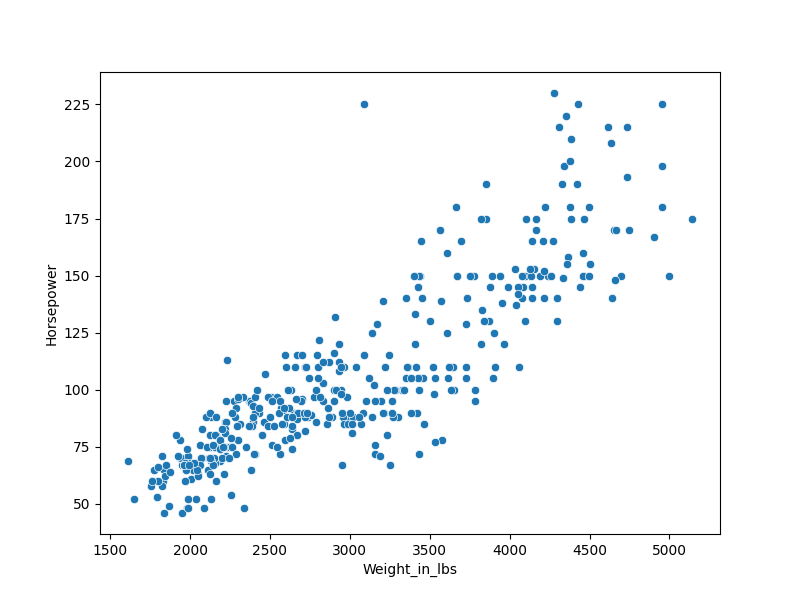

In [5]:
from IPython.display import Image

Image(filename='groupchat/weight_vs_horsepower.png')

## Example 2

In [6]:
user_proxy.reset()
coder.reset()
critic.reset()
groupchat = autogen.GroupChat(agents=[user_proxy, coder, critic], messages=[], max_round=20)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)
user_proxy.initiate_chat(manager, message="download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and show me a plot that tells me about the amount of each weather . Save the plot to a file. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.")


User_proxy (to chat_manager):

download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and show me a plot that tells me about the amount of each weather . Save the plot to a file. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.

--------------------------------------------------------------------------------
Coder (to chat_manager):

I will first download the data and print the fields of the dataset. Then, I'll create a plot and save it to a file. Please execute the following Python code to download the data, print the fields, and generate the weather plot.

```python
# filename: weather_plot.py

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)
print("Fields in the dataset:")
print(data.columns)

# Count the occurrences of each weather type
weather_co

### The original chart before critic's suggestion

Fields in the dataset:
Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')
Plot has been saved to 'weather_plot.png'.


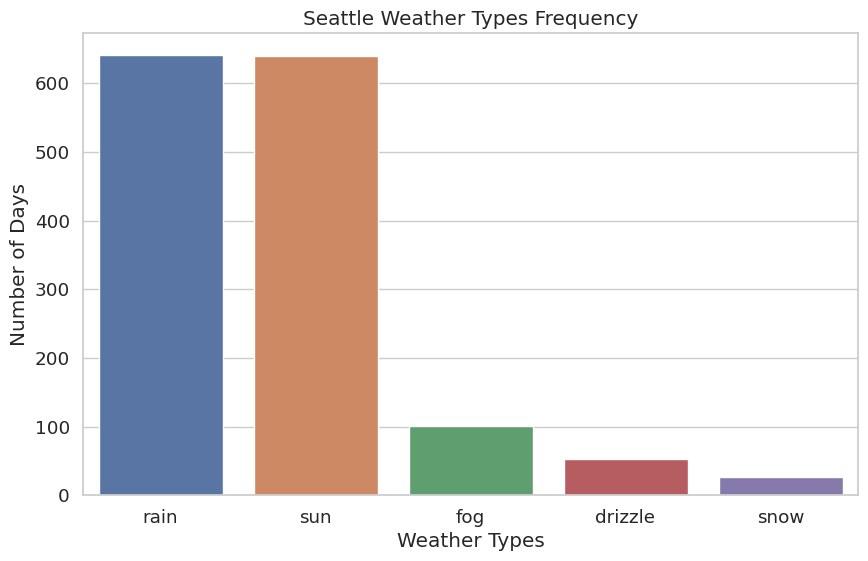

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)
print("Fields in the dataset:")
print(data.columns)

# Count the occurrences of each weather type
weather_counts = data['weather'].value_counts()

# Create a bar plot of weather occurrences
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 6))
weather_plot = sns.barplot(x=weather_counts.index, y=weather_counts.values)

# Add labels and title
weather_plot.set(xlabel='Weather Types', ylabel='Number of Days', title='Seattle Weather Types Frequency')
plt.savefig('weather_plot.png')

print("Plot has been saved to 'weather_plot.png'.")

### The final figure

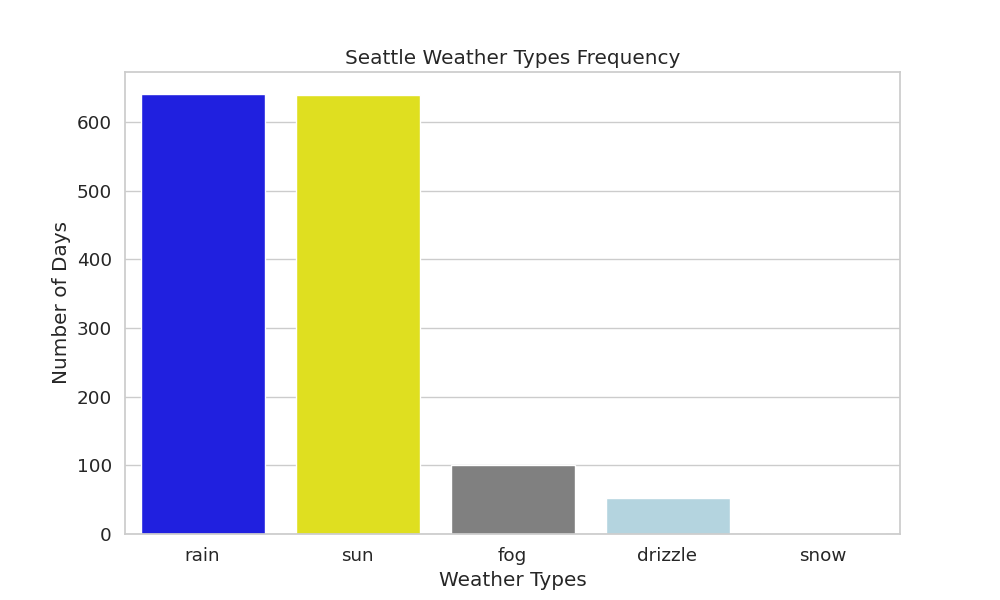

In [8]:
from IPython.display import Image

Image(filename='groupchat/improved_weather_plot.png')